# Translate Products to Category

*Author: Maggie Yundi Li, Liling Tan*



<img src="tutorial/rakuten_global_categories.png" style="height:75%;width:75%;"/>
<div align="center">
    Product Category Screenshot from Rakuten Global on 2nd July 
</div>

### TLDR
After completing this tutorial, you will know:
- Basic cleaning routine for product titles and text input alike
- Data exploration techniques for text, such as **topic modelling**
- How to classify product titles into their categories using Random Forest
- **How to classify product titles into their categories using Seq2Seq generation**

### Otherwise...
Product categorization is a key component of e-commerce platforms, like Rakuten and Amazon, to effectively organize and retrieve relevant products. It has always been a challenge to predict a product’s category as defined in an expansive taxonomy tree, given its title [1]. For example, Rakuten.com categorizes “Dr. Martens Air Wair 1460 Mens Leather Ankle Boots” under “Clothing, Shoes & Accessories -> Shoes -> Men -> Boots" [1]. 

In this notebook, we introduce our approach to this challenge, using sequence-to-sequence(Seq2Seq) generation, using dataset from the Rakuten Data Challenge [1]. The training set contains 800,000 entries and the testing set 200,000.

This notebook accompanies the SIGIR e'Com 2018 paper, *Unconstrained Product Categorization with Sequence-to-Sequence Models.* [2] This paper details our experiments using attentional sequence-to-sequence models and their results in the RIT-SG submissions for the Rakuten Data Challenge at SIGIR eCom'18. The goal of the challenge is to predict the multi-level hierarchical product category given the e-commerce product title. We build several sequence-to-sequence models to generate non-constrained product category labels. Training on data from the aforementioned data challenge, our bidirectional attention model performs best on their test set, with a balanced F-score of 0.8256. Such a performance placed us at the 6th place, demonstrating that our sequence-to-sequence generation approach is adequate for hierarchical product categorization.

### Let's get started!




## 1. Data Exploration

### 1.1 Basic Processing

First, let's load the training and testing set using pandas.

In [3]:
import pandas as pd

df_train = pd.read_csv('rdc-catalog-train.tsv', sep='\t', header=None)
df_test = pd.read_csv('rdc-catalog-test.tsv', sep='\t', header=None)

df_train = df_train.rename(columns={0:'text', 1:'label'})
df_test = df_test.rename(columns={0:'text', 1:'label'})

These are 5 random entries from the training set.

In [10]:
df_train.sample(n=5)

,text,label
748409,Car White 2 SMD 5050 Error Free LED 31mm Festo...,2199>915>3404>3368
630389,Proscan PSB3713-OP 37-Inch Bluetooth Ultra-Sli...,3292>1005>1655
755081,Nike Men's Hyperdunk 2016 Low Basketball Shoe,1608>1206>2631>3545
311248,Whitfield Lighting PT2276DG Ariel 1-Light Tear...,4015>282>3469>2374
83425,Interparts - ATV-PO-8-347 - Complete Axle Desc...,2199>4592>12


The casing of product titles is clearly all over the place. It will help us reduce the vocabulary size to lowercase them all.

In [9]:
df_train['text'] = df_train['text'].str.lower()

## Let's check the result
df_train.sample()

,text,label
45613,new laptop battery for sony vaio vgn-sr240n/b ...,3292>1370>4767>3975>1420


In [10]:
import re

df_train['num_words'] = df_train['text'].str.split().apply(len)
df_train['num_char'] = df_train['text'].str.replace(" ", "").apply(len)
df_train['num_punc'] = df_train['num_char'] - df_train['text'].apply(
    lambda x: len(re.findall('[\w]', str(x))))

df_train.sample()

,text,label,num_words,num_char,num_punc
167823,ac power adapter charger for toshiba satellite...,3292>1370>4767>3975>1411,17,96,5


In [11]:
# Repeat the above for the test set
df_test['text'] = df_test['text'].str.lower()
df_test['num_words'] = df_test['text'].str.split().apply(len)
df_test['num_char'] = df_test['text'].str.replace(" ", "").apply(len)
df_test['num_punc'] = df_test['num_char'] - df_test['text'].apply(
    lambda x: len(re.findall('[\w]', str(x))))

Now let's try to explore some relations between the label and the text features.

First we split the label string into a list of sub-categories.

In [12]:
df_train['label_list'] = df_train['label'].str.split('>')

## Split the sub-categories into first level and the rest
df_train['first_level'] = df_train['label_list'].apply(lambda x: x[0])
df_train['other_level'] = df_train['label_list'].apply(lambda x: x[1:])

df_train[['label','other_level','first_level']].sample()

,label,other_level,first_level
475048,3292>1370>289>4073,"[1370, 289, 4073]",3292


Now how's the label distribution like?

In [36]:
unique_labels = set(df_train['label'])
print('Number of unique labels:', len(unique_labels))

Number of unique labels: 3008


To get a sense of the label distributiion without being overwhelmed by all 3k+ labels, let's take a look at the top and bottom 5 frequent labels 

In [49]:
from collections import Counter
label_count = Counter(df_train['label']).most_common()

print('5 most frequent labels:')
print(*label_counter[:5], sep = "\n")
print('\n 5 least frequent labels:')
print(*label_counter[-5:], sep = "\n")

5 most frequent labels:
('2199>4592>12', 69915)
('3292>3581>3145>2201', 30146)
('4015>2337>1458>40', 25481)
('3292>114>1231', 21813)
('3292>1370>4767>3975>1420', 19797)

 5 least frequent labels:
('3730>2720>4005>2321', 1)
('2199>1952>3163>1822', 1)
('3292>2790>1053>2721', 1)
('4015>2824>2964>2473>4559>1399>2913', 1)
('2075>3671>4896>3337', 1)


Evidently, the label distribution is highly uneven. We have at our hands a classic class imbalance problem.

What about the first level categories then?

In [52]:
first_lev_count = Counter(df_train['first_level']).most_common()
print(*first_lev_count, sep = "\n")

('4015', 268295)
('3292', 200945)
('2199', 96714)
('1608', 85554)
('3625', 29557)
('2296', 28412)
('4238', 23529)
('2075', 20086)
('1395', 18847)
('92', 8172)
('3730', 8113)
('4564', 5648)
('3093', 5098)
('1208', 1030)


Not as bad, but still rather unbalanced, with 1k of category "1208" in constrast of 200k+ of category "4015". Let's see the distribution visualised.

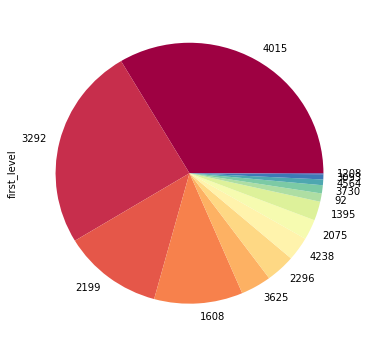

In [89]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

vc = df_train['first_level'].value_counts()

## Change the "kind" parameter to "bar" if you prefer a histogram
vc.plot(kind='pie', colormap='Spectral', figsize=(6, 6))

### 1.2 Noise Detection

Product titles on e-commerce platforms are usually noisy. And our dataset is no exception. Let's filter them out and see some examples

In [129]:
import string

ascii_set = set(string.printable)

## Expand this list if there are symbols you don't think are noise
expansion = ['®', '”', '™', 'é', '°', '–', '“', '³', 'ü', 'ū', 'Ë', '©', '®',
            '½', '″', '’', '¯', 'à', '‘', 'è', '‘', '’', '|', '&', 
            'ë', 'ē', 'é', '\xa0', 'Ç', 'µ', '&Nbsp;', 'é', 'ó']

ascii_set.update(expansion)

# Note there are cases of these XML escape chars in the title too.
['&Nbsp;']

def has_non_ascii(s):
    s = str(s)
    return any(ch for ch in s if ch not in ascii_set)

latin1_titles = []

def append_to_latin1_list(x):
    if has_non_ascii(x):
        latin1_titles.append(x)

latin1 = df_train['text'].apply(append_to_latin1_list)
print('Number of noisy entries:', len(latin1_titles))
print(*latin1_titles[:10], sep='\n')

Number of noisy entries: 874
30" Landing Net Landing Net,30� Solid Hoop,6 foot Handle
Superb Choice� 6-cell Apple MacBook Pro 13.3" MD101*/A (only for mid 2011 Version) Laptop Battery
Acr Electronics Acr Antenna F/Rapidfix, Sat Ii & Globalfix - Black  Activation Method = None ; Battery Repla
MONTER�A, COLOMBIA Street Sign Colombian flag city country road wall gift
Fight Cancer - Kick Cancer's Ass Women's T-Shirt by American Apparel by SpreadshirtÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã…Â¾Ãƒâ€šÃ‚Â¢
MightySkins Protective Vinyl Skin Decal for OtterBox Defender Pixel 5� Case wrap cover sticker skins Diamond Plate
Pokemon Men's Gengar Evoultion Group  Pok� Ball Purples Bi-Fold
Don't Give A Schnitzel Funny Oktoberfest Men's T-Shirt by SpreadshirtÃ¢â€žÂ¢
Slasher Hyper Series Dual Row LED Light Bar 5760 Lumens 13.5� 72W
BEL-RAY�2T Mineral Engine Oil is a 2-stroke motorcycle oil specially formulated


You may feel like removing these noisy entries but we decided otherwise. Systemetic noise can be helpful for our task. For a more detailed explanation, see section 3 in [2].

### 1.3 Topic Modelling
To better understand the product titles, let's try topic modelling. 

Topic modelling is an unsupervised approach to model each text entry as a finite mixture over an underlying set of topics[3]. Each topic is a set of word probabilities[3]. Topic modelling thus automatically identifies patterns in text.

Here we use Gensim's Latent Dirichlet Allocation algorithm for our topic modelling.
(Read [3] for a detailed explanation of this algorithm.)

In [9]:
# Bug in Gensim package regarding csvcorpus
# It turned out csvcorpus is still experimental as tracked in their github issue
# Therefore, using the codes below for now.
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python
import nltk
import spacy
from spacy.lang.en import English

spacy.load('en')
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    
    # Ignoring words with length of 1
    tokens = [token for token in tokens if len(token) > 1]
    # Ignoring stopwords
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

As topic modelling is unsupervised, we combine the training and testing product titles to generate our topic distribution.

In [12]:
df_train['tokenized_text'] = df_train['text'].apply(prepare_text_for_lda)
df_test['tokenized_text'] = df_test['text'].apply(prepare_text_for_lda)
text_data = df_train['tokenized_text'].tolist() + df_test['tokenized_text'].tolist()

In [9]:
from gensim import corpora
import pickle
import pyLDAvis.gensim
from gensim.models import LdaMulticore

# Build gensim dictionary and bag of words list, required for LDA input
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# Save the corpus and dictionary for future usage
pickle.dump(corpus, open('corpus_combined.pkl', 'wb'))
dictionary.save('dictionary_combined.gensim')

# Train LDA topic model using multi-cores
# Play around with the num_topics parameter 
# and change the number of workers according to your device
num_topics = 30
lda = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, workers=6)
lda.save('model30.gensim')

In [10]:
# A glimpse into the top 3 contributing words to each topic
topics = lda.print_topics(num_words=3)
for topic in topics:
    print(topic)

(29, '0.041*"battery" + 0.038*"compatible" + 0.037*"cell"')
(18, '0.031*"lamp" + 0.025*"projector" + 0.020*"bulb"')
(25, '0.072*"filter" + 0.063*"replacement" + 0.053*"water"')
(3, '0.030*"shirt" + 0.023*"black" + 0.012*"large"')
(24, '0.021*"cartridge" + 0.018*"toner" + 0.016*"black"')
(4, '0.040*"light" + 0.031*"led" + 0.023*"white"')
(16, '0.011*"lb" + 0.009*"sign" + 0.009*"starter"')
(20, '0.015*"oz" + 0.014*"de" + 0.012*"women"')
(13, '0.017*"multi" + 0.015*"table" + 0.015*"cap"')
(2, '0.024*"..." + 0.022*"motorcycle" + 0.018*"krator"')
(0, '0.076*"replacement" + 0.076*"battery" + 0.049*"12v"')
(8, '0.068*"replacement" + 0.068*"volt" + 0.067*"run"')
(23, '0.064*"mm" + 0.031*"unique" + 0.030*"bargains"')
(28, '0.014*"black" + 0.012*"case" + 0.009*"floor"')
(27, '0.031*"case" + 0.021*"series" + 0.017*"iphone"')
(22, '0.011*"hair" + 0.009*"inch" + 0.007*"brass"')
(6, '0.062*"oz" + 0.014*"womens" + 0.012*"spray"')
(5, '0.019*"music" + 0.017*"book" + 0.016*"belt"')
(14, '0.064*"skin" +

In [11]:
# Visualisation using pyLDAvis in 2-dimension space
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, 'model30.html')
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [13]:
# Save the topic distribution for each product title
topic_column_list = ['topic_' + str(i) for i in range(0,num_topics)]

df_train['bow'] = df_train['tokenized_text'].apply(dictionary.doc2bow)
df_train['topic_distribution'] = df_train['bow'].apply(lambda row:lda.get_document_topics(row))

df_test['bow'] = df_test['tokenized_text'].apply(dictionary.doc2bow)
df_test['topic_distribution'] = df_test['bow'].apply(lambda row:lda.get_document_topics(row))

In [19]:
for i, topic in zip(range(0, num_topics), topic_column_list):
    df_train[topic] = 0.0
    df_test[topic] = 0.0

def assign_topic_prob(row):
    for item in row['topic_distribution']:
        row['topic_'+str(item[0])] = item[1]
        #print(row['topic_'+str(item[0])])
    
    return row

df_train = df_train.apply(assign_topic_prob, axis=1)
df_test = df_test.apply(assign_topic_prob, axis=1)

In [33]:
# Check the probability for the first 5 topics of the first 10 entries
df_train[['topic_0','topic_1','topic_2','topic_3','topic_4']][:10]

,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.132077,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.016667,0.016667,0.016667,0.016667,0.016667
3,0.788755,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.443282
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.069726,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
df_train.to_csv('rdc-catalog-train-30topic.tsv', sep='\t', index=False)
df_test.to_csv('rdc-catalog-test-30topic.tsv', sep='\t', index=False)

### 1.4 Universal Sentence Encoding

The Universal Sentence Encoder encodes greater-than-word length text, such as sentences or phrases, into high dimensional vectors that can be used for text classification and other natural language tasks[4]. It accepts input of variable length English text and outputs a 512 dimensional vector for each input entry. The universal-sentence-encoder model we use is trained with a deep averaging network (DAN) encoder[4]. (Read [3] for the paper, *Universal Sentence Encoder*, for a comprehensive elaboration.)

We use encodings(or embeddings) generated by Universal Sentence Encoder as an additional feature for our data.

**Caveat**: The following code in this section may throw a ResourceEchaustedError on Jupyter Notebook if your GPU ram is not large enough. Run the python script, dan_embedding.py, in the tutorial folder instead to be safe.

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
import os

module_url = "https://tfhub.dev/google/universal-sentence-encoder/1"
os.environ["TFHUB_CACHE_DIR"] = os.getcwd() + "/tfhub_models2/"
embed = hub.Module(module_url)

INFO:tensorflow:Using /home/maggie/tfhub_models2/ to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/1'.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/home/maggie/tfhub_models2/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/home/maggie/tfhub_models2/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/home/maggie/tfhub_models2/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/home/maggie/tfhub_models2/c6f

In [10]:
train_text = df_train['text'].tolist()
test_text = df_test['text'].tolist()

In [ ]:
# Reference: https://colab.research.google.com/drive/1lxRclJablHF-veuRzWBgJ9gaqMNo6fPa#forceEdit=true&offline=true&sandboxMode=true&scrollTo=s2Xk7pzom5-3
# Author: Liling Tan

def get_embeddings(text_list):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        sentence_embeddings = session.run(embed(text_list))
    return sentence_embeddings

train_embeddings = get_embeddings(train_text)
test_embeddings = get_embeddings(test_text)

In [ ]:
# Save the embeddings if you do not wish to wait for another hour the next time 
np.save('test_dan_embedding.npy', test_embeddings)
np.save('train_dan_embedding.npy', train_embeddings)

## The Road Often Traveled - Classification

Now let's try to use a conventional approach to deal with the task at hand, classification with the popular random forest classifier.

In [4]:
from scipy.sparse import hstack, save_npz, load_npz
from tqdm import tqdm
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

Although it is definitely feasible to regard each hierarchical category as a unique label before carrying out classification on 3k+ labels, it is better to perform "hierarchical" classification in order to at least partially preserve the tree structure of sub-categories in our process.

### 2.1 First Level Category Classification

To make pandas dataframe work with sklearn Feature Union, we use the ItemSelector suggested in the sklearn documentation.

In [5]:
# Reference: http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, titles):
        return [{'word_count_larger_than_1': 1 if len(str(text).split())>1 else 0,
                 'word_count_larger_than_5': 1 if len(str(text).split())>5 else 0,
                 'char_count_larger_than_5': 1 if len(''.join(str(text).split()))>5 else 5}
                for text in titles]

In [10]:
num_topics = 30
topic_column_list = ['topic_' + str(i) for i in range(0, num_topics)]

# Feature Union n_jobs is buggy. Beware.
transformer_pipeline = FeatureUnion(
    transformer_list=[
        ('topic', Pipeline([
            ('selector', ItemSelector(key=topic_column_list)),
        ])),
        ('count', Pipeline([
            ('selector', ItemSelector(key='text')),
            ('stats', TextStats()),
            ('vect', DictVectorizer()),
        ])),
        ('count_vect_char', Pipeline([
            ('selector', ItemSelector(key='text')),
            ('count_vect', CountVectorizer(analyzer='char',
                                     ngram_range=(4,7), stop_words='english', token_pattern='.*')),
            ('best', TruncatedSVD(n_components=120)),
        ])),
        ('tfidf_vect', Pipeline([
            ('selector', ItemSelector(key='text')),
            ('count_vect', TfidfVectorizer(analyzer='word', tokenizer=prepare_text_for_lda,
                                     ngram_range=(1,2), stop_words='english', token_pattern='.*')),
            ('best', TruncatedSVD(n_components=120)),
        ])),# Performance saturates around 120 components
    ],
)

In [32]:
transformed_train = transformer_pipeline.fit_transform(df_train)
save_npz('transformed_30topic.npz', transformed_train)
transformed_test = transformer_pipeline.fit_transform(df_test)
save_npz('transformed_30topic_test.npz', transformed_test)


Concatenate the embeddings from universal sentence encoder with the transformed features

In [5]:
transformed_train = load_npz('transformed_30topic.npz')
transformed_test = load_npz('transformed_30topic_test.npz')
embedding = np.load('train_dan_embedding.npy')
embedding_test = np.load('test_dan_embedding.npy')
transformed_test = hstack([transformed_test, embedding_test])
transformed_train = hstack([transformed_train, embedding])

For the sake of time-saving, we do a 8-2 split on the training set to make it into training and validation set.
<br>
If you have more time or resources, you may wish to use sklearn.model_selection.cross_val_score for a cross-validated performance of the model.

In [13]:
train_x, val_x, train_y, val_y = train_test_split(
            transformed_train, df_train['first_level'], test_size=0.2, random_state=2)

Note that we are using the hyperparameter class_weight="balanced" to mitigate the influence of class imbalance.
<br>
For a comparison, change "balanced" to None and you will notice a drop in performance.

In [14]:
# Adjust the hyperparameters listed in the output below.
# Set verbose to 0 to minimize output during training
rand_forest_clf = RandomForestClassifier(
                    n_estimators=50, min_samples_leaf=10,
                    class_weight="balanced", verbose=2, n_jobs=50)
rand_forest_clf.fit(train_x, train_y)

building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50

building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50building tree 38 of 50building tree 39 of 50
building tree 40 of 50
building tree 41 of 50

building tree 42 of 50
building tree 43 of 50
building tree 44 of 50

[Parallel(n_jobs=50)]: Done   3 out of  50 | elapsed:  4.3min remaining: 67.4min
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:  4.5min remaining:  3.3min
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:  4.8min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=50, oob_score=False, random_state=None,
            verbose=2, warm_start=False)

In [16]:
val_prediction = rand_forest_clf.predict(val_x)
print(classification_report(val_prediction, val_y))

[Parallel(n_jobs=50)]: Done   3 out of  50 | elapsed:    0.5s remaining:    8.0s
[Parallel(n_jobs=50)]: Done  29 out of  50 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:    0.8s finished


             precision    recall  f1-score   support

       1208       0.64      0.55      0.59       240
       1395       0.50      0.55      0.53      3545
       1608       0.93      0.90      0.92     18039
       2075       0.55      0.51      0.53      4463
       2199       0.82      0.82      0.82     19321
       2296       0.95      0.63      0.76      8584
       3093       0.66      0.63      0.64      1079
       3292       0.91      0.94      0.92     38363
       3625       0.75      0.79      0.77      5573
       3730       0.66      0.51      0.58      2145
       4015       0.81      0.86      0.83     50226
       4238       0.65      0.55      0.60      5633
       4564       0.70      0.63      0.67      1236
         92       0.82      0.89      0.85      1553

avg / total       0.83      0.83      0.83    160000



In [17]:
rand_forest_clf = RandomForestClassifier(
                    n_estimators=50, min_samples_leaf=10,
                    class_weight="balanced", verbose=1, n_jobs=50)
rand_forest_clf.fit(transformed_train, df_train['first_level'])

[Parallel(n_jobs=50)]: Done   2 out of  50 | elapsed:  5.8min remaining: 140.2min
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:  6.4min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=50, oob_score=False, random_state=None,
            verbose=1, warm_start=False)

In [12]:
df_train = pd.read_csv('rdc-catalog-train-30topic.tsv', sep='\t')
df_test = pd.read_csv('rdc-catalog-test-30topic.tsv', sep='\t')

In [ ]:
first_lvl_pred_test = rand_forest_clf.predict(transformed_test)

df_test['first_level'] = first_lvl_pred_test

df_test.to_csv('rdc-catalog-test-30topic-first-lvl.tsv', index=False, sep='\t')

In [18]:
import pickle

# Save the classifier to pickle for future usage
with open('first_lvl_rfclf.pkl', 'wb') as file:
    pickle.dump(rand_forest_clf, file)

### 2.2 Finer Level Classification

Map the original label strings back to a list of numbers for easier processing

In [13]:
unique_labels = list(set(df_train['label']))
labels2idx = {l:i for i, l in enumerate(unique_labels)}
idx2labels = {v:k for k,v in labels2idx.items()}

df_train['label_idx'] = [labels2idx[l] for l in df_train["label"]]


As sparse matrices are unsubscribable, we will need to do the transformation and concatenation again, label by label.

In [ ]:
train_test_per_label = {}

In [84]:
import time

df_test['first_level'] = df_test['first_level'].astype('int64')
labels = set(df_train['first_level'])

for label in tqdm(labels):
    start = time.time()
    curr_embedding = embedding[df_train['first_level']==label]
    curr_embedding_test = embedding_test[df_test['first_level']==label]
    curr_df_train = df_train[df_train['first_level']==label]
    curr_df_test = df_test[df_test['first_level']==label]
    print('Masking took', label, time.time() - start)
    
    start = time.time()
    curr_transformed = transformer_pipeline.fit_transform(curr_df_train)
    print('Fit transform took', label, time.time() - start)
    
    start = time.time()
    curr_transformed_test = transformer_pipeline.transform(curr_df_test)
    print('Transform took', label, time.time() - start)
    
    start = time.time()
    curr_train_input = hstack([curr_transformed, curr_embedding])
    print('Hstack train took', label, time.time() - start)
    
    start = time.time()
    curr_test_input = hstack([curr_transformed_test, curr_embedding_test])
    print('Hstack test took', label, time.time() - start)
    
    curr_df_test = curr_df_test[['text', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'num_words', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'first_level']]
    train_test_per_label[label] = (curr_train_input, 
                                   curr_test_input, 
                                   curr_df_test, 
                                   curr_df_train)




  0%|          | 0/4 [00:00<?, ?it/s]

Masking took 2296 0.19162964820861816
Fit transform took 2296 59.45334792137146
Transform took 2296 4.24029541015625
Hstack train took 2296 1.0592586994171143





 25%|██▌       | 1/4 [01:05<03:16, 65.34s/it]

Hstack test took 2296 0.3817753791809082
Masking took 1208 0.048041582107543945





 50%|█████     | 2/4 [01:11<01:11, 35.65s/it]

Fit transform took 1208 5.78741717338562
Transform took 1208 0.09234833717346191
Hstack train took 1208 0.021400928497314453
Hstack test took 1208 0.0025043487548828125
Masking took 2075 0.17715215682983398
Fit transform took 2075 87.45742225646973
Transform took 2075 3.859410047531128
Hstack train took 2075 0.7013516426086426
Hstack test took 2075 0.1875760555267334





 75%|███████▌  | 3/4 [02:43<00:54, 54.56s/it]

Masking took 3292 0.7706325054168701
Fit transform took 3292 648.1906824111938
Transform took 3292 46.46827554702759
Hstack train took 3292 9.096911191940308





100%|██████████| 4/4 [14:30<00:00, 217.60s/it]




Hstack test took 3292 2.1256163120269775


That took quite a while didn't it. Let's save the transformed arraies into a pickle file to save us from redoing this step, in case this current session ends before you intend to.

In [85]:
with open('train_test_per_label.pkl', 'wb') as file:
    pickle.dump(train_test_per_label, file)

Now let's build a classifier for each first level category. During each classification within the first level,
Uncomment the commented block at the bottom if you wish to make predictions for an unseen test set.

*Caveat*: As shown in the warnings in the output, cross-validation does not apply well to classes of size smaller than number of splits. This is because many categories have very few occurences, as shown in the data exploration section.

In [15]:
import pickle

with open('train_test_per_label.pkl', 'rb') as file:
    train_test_per_label = pickle.load(file)

In [16]:
classifiers_per_label = {}
predictions_per_label = {}
fscore_per_label = {}


for label, (curr_train_input, 
            curr_test_input, 
            curr_df_test,
            curr_df_train) in tqdm(train_test_per_label.items()):

    rand_forest_clf = RandomForestClassifier(
                    n_estimators=30, class_weight="balanced", verbose=1, n_jobs=30)
    
    scores = cross_val_score(rand_forest_clf, curr_train_input, curr_df_train['label_idx'],
                         scoring='f1_weighted', cv=4, n_jobs=2)
    fscore_per_label[label] = scores

#     rand_forest_clf.fit(curr_train_input, curr_df_train['label_idx'])
    
#     classifiers_per_label[label] = rand_forest_clf
#     predictions = rand_forest_clf.predict(curr_test_input)
#     curr_df_test['predictions'] = predictions
#     predictions_per_label[label] = curr_df_test

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:   39.2s remaining:  9.1min
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:   38.7s remaining:  9.0min
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   42.8s finished
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   44.3s finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.1s remaining:    1.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.3s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[

[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed: 29.5min remaining: 413.5min
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed: 32.5min finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    2.8s remaining:   39.5s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    9.8s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed: 33.3min finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    3.0s remaining:   41.6s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    9.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(

[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   27.9s finished
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   27.5s finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-

[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.2s remaining:    2.9s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 71%|███████▏  | 10/14 [1:13:47<29:30, 442.74s/it][Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:   18.2s remaining:  4.3min
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:   18.7s remaining:  4.4min
[Parallel(n_jobs=30)]: Done  30 

 93%|█████████▎| 13/14 [1:16:25<05:52, 352.73s/it]/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:  4.4min remaining: 61.8min
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:  4.6min remaining: 63.9min
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  5.2min finished
[Parallel(n_jobs=30)]: Done   2 out of  30 | elapsed:    0.8s remaining:   10.7s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:  5.4mi

Let's take a look at the cross validation f-score by label.

In [19]:
for label, scores in fscore_per_label.items():
    print('Avg cross-val F-score on label', label, np.mean(scores))

Avg cross-val F-score on label 1608 0.8105554892550797
Avg cross-val F-score on label 3625 0.6404786974946927
Avg cross-val F-score on label 4238 0.6421230014292477
Avg cross-val F-score on label 4015 0.6736708295206733
Avg cross-val F-score on label 92 1.0
Avg cross-val F-score on label 3730 0.5089561405664029
Avg cross-val F-score on label 1395 0.5311795525857907
Avg cross-val F-score on label 4564 0.6397904962790137
Avg cross-val F-score on label 3093 0.7421185995699195
Avg cross-val F-score on label 2199 0.8540664542038003
Avg cross-val F-score on label 2296 0.2910673186699205
Avg cross-val F-score on label 1208 0.5382793971772365
Avg cross-val F-score on label 2075 0.5212634636970765
Avg cross-val F-score on label 3292 0.8068922102316692


As we can see from the f-score above, our 2-tiered classification method fared reasonably, although quite forseeably performing less well on the smaller categories.

You can also use the code below to format your test output.

In [90]:
# predictions = pd.DataFrame()
# for label, df in predictions_per_label.items():
#     predictions = pd.concat([predictions, df['predictions']], sort=True)
# predictions = predictions.sort_index()

# # Map the predicted labels back to their original form
# final_predictions = [idx2labels[pred] for pred in predictions[0]]

## The Road We Traveled - Seq2Seq

Previous approaches to product categorization focused on mapping product information (titles, descriptions, images, etc.) to the specific categories based on the existing labels from the training data. Despite the effectiveness of such approaches, products can only be classified into the categories given by the platform. However, the static product category hierarchies would not be able to adapt to the ever-growing number of products on the e-commerce platform. We want to automatically learn the cross-pollination of sub-categories beyond the pre-defined hierarchy, instead of imposing the hard boundaries inherited from higher level categories.

## Visualise and Interpret Category Predictions

## At the End

I hope you enjoyed this longwinded tutorials. It's impressive that you have gone so far. Why not give our paper a read then, if you haven't?

For any feedbacks and questions, feel free to contact me or submit an issue/pull requests in our github repository. We will try to get back to you as soon as we can.

Until next time.

## References:
